In [1]:
import backtrader as bt
from backtrader import Indicator
import numpy as np
import datetime
import pandas as pd
import pandas_datareader.data as web
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

C:\Users\tbndo\Anaconda3\envs\build\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
class linearRegressionIndicator(Indicator):
    alias = ('LR', )
    lines = ('linear_regression', )
    params = (
        ('window', 300),
        ('lookback', 60),
    )
    
    iter = 0
    
    def next(self):
        if (self.iter > self.params.window + 1 + self.params.lookback):
            
            raw_prices = self.data.get(size = self.params.window + 1 + self.params.lookback) #
            prices = np.array(raw_prices)
            
            returns = pd.Series(prices).pct_change(periods = 1)
            
            train_data = pd.DataFrame()
            for i in range(0, self.params.lookback + 1):
                series = returns.shift(periods = i)
                series.name = f"lag_{i}"
                train_data = pd.concat([train_data, series], axis = 1)
                
            train_data = train_data.dropna().iloc[:self.params.window]

            X = train_data.iloc[:, 1:]
            y = train_data.loc[:, 'lag_0']
            y = pd.Series(np.where(y > 0, 1, 0))
            
            clf = RandomForestClassifier()
            clf.fit(X, y)
            
            inputt = np.array(train_data.iloc[self.params.window - 1, ][:-1]).reshape(1, -1)
            prediction = clf.predict(inputt)
            self.lines.linear_regression[0] = prediction
            
            print(f"Iteration: {self.iter}. Prediction: {self.lines.linear_regression[0]}")
        self.iter += 1

In [3]:
class myStrategy(bt.Strategy):
    
    params = (
        ('window', 300),
    )
    
    def log(self, txt, dt = None):
        # logging function fro the strategy
        dt = dt or self.getdatabyname('AAPL').datetime.date(0)
        print(f"{dt.isoformat()}, {txt}")
    
    def __init__(self):
        
        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None   
        
        self.data_close = self.getdatabyname('AAPL').close
        self.prediction = linearRegressionIndicator(self.data_close, window = self.params.window)
        
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # do nothing
            pass
    
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f"BUY EXECUTED: {order.executed.price}, {order.executed.value}, {order.executed.comm}")
            elif order.issell():
                self.log(f"SELL EXECUTED: {order.executed.price}")
            self.bar_executed = len(self)
        elif order.status in [order.Cancelled, order.Margin, order.Rejected]:
            self.log(f"Order Cancelled, Margin, Rejected")
            
        # Write down: no pending order
        self.order = None
    
    def next(self):
        # Simply log the closing price of the series from the reference
        self.log(f"Close: {self.data_close[0]}")
        
        if self.order:
            return
        
        # if not in position
        if not self.position:
            # if our conditions are met
            if self.prediction[0]:
                # buy
                self.log(f"BUY CREATE: {self.data_close[0]}")

                # keep track of the order to avoid making another one
                self.order = self.buy(stake = 100)
        
        # if in position, we might consider selling
        else:
            if (not self.prediction[0]) or (len(self) == self.data_close.buflen()):
                self.log(f"SELL CREATE: {self.data_close[0]}")
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy(stake = -100)

In [4]:
cerebro = bt.Cerebro()
cerebro.addstrategy(myStrategy)

0

In [5]:
class PandasData(bt.feed.DataBase):
    params = (
        ('datetime', None),
        ('open', -1),
        ('high', -1),
        ('low', -1),
        ('close', -1),
        ('volume', -1),
        ('openinterest', None),
    )
    
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2016, 10, 31)
is_first = True
# Not the same set of symbols as in other blog posts
symbols = ["AAPL"] #, "GOOG", "MSFT", "AMZN", "SNY", "NTDOY", "IBM", "HPQ", "QCOM", "NVDA"
plot_symbols = ["AAPL"]
#plot_symbols = []
for s in symbols:
    data = web.DataReader(
            name = s,
            data_source = 'yahoo',
            start = '2010-01-01',
            end = '2016-10-31'  
        ).rename(
            columns = {
                'Open': 'open',
                'High': 'high',
                'Low': 'low',
                'Close': 'close',
                'Volume': 'volume'
            }
        )
    
    data = bt.feeds.PandasData(dataname = data, fromdate = start, todate = end)
    if s in plot_symbols:
        if is_first:
            data_main_plot = data
            is_first = False
        else:
            data.plotinfo.plotmaster = data_main_plot
    else:
        data.plotinfo.plot = False
    cerebro.adddata(data, name = s)    # Give the data to cerebro

In [6]:
# Set our desired cash start
cerebro.broker.setcash(100000.0)
# 0.1% ... divide by 100 to remove the %
cerebro.broker.setcommission(commission = 0.001)

# add sizers
cerebro.addsizer(bt.sizers.FixedSize, stake = 100)

# Analyzer
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='TradeAnalysis')
cerebro.addanalyzer(bt.analyzers.SharpeRatio,timeframe=bt.TimeFrame.Days,riskfreerate=0.0, _name='SharpeAnalysis')
cerebro.addanalyzer(bt.analyzers.DrawDown , _name='DrawDownAnalysis') 

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
results = cerebro.run(maxcpus=1)

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
Iteration: 362. Prediction: 0.0
Iteration: 363. Prediction: 0.0
Iteration: 364. Prediction: 0.0
Iteration: 365. Prediction: 1.0
Iteration: 366. Prediction: 1.0
Iteration: 367. Prediction: 1.0
Iteration: 368. Prediction: 0.0
Iteration: 369. Prediction: 0.0
Iteration: 370. Prediction: 0.0
Iteration: 371. Prediction: 0.0
Iteration: 372. Prediction: 0.0
Iteration: 373. Prediction: 0.0
Iteration: 374. Prediction: 1.0
Iteration: 375. Prediction: 1.0
Iteration: 376. Prediction: 0.0
Iteration: 377. Prediction: 0.0
Iteration: 378. Prediction: 0.0
Iteration: 379. Prediction: 0.0
Iteration: 380. Prediction: 1.0
Iteration: 381. Prediction: 1.0
Iteration: 382. Prediction: 0.0
Iteration: 383. Prediction: 1.0
Iteration: 384. Prediction: 0.0
Iteration: 385. Prediction: 0.0
Iteration: 386. Prediction: 1.0
Iteration: 387. Prediction: 0.0
Iteration: 388. Prediction: 0.0
Iteration: 389. Prediction: 0.0
Iteration: 390. Prediction: 0.0
Iteration: 391. Prediction: 0.0
Iter

2016-09-30, Order Cancelled, Margin, Rejected
2016-09-30, Close: 113.05000305175781
2016-09-30, SELL CREATE: 113.05000305175781
2016-10-03, Order Cancelled, Margin, Rejected
2016-10-03, Close: 112.5199966430664
2016-10-03, SELL CREATE: 112.5199966430664
2016-10-04, Order Cancelled, Margin, Rejected
2016-10-04, Close: 113.0
2016-10-04, SELL CREATE: 113.0
2016-10-05, Order Cancelled, Margin, Rejected
2016-10-05, Close: 113.05000305175781
2016-10-05, SELL CREATE: 113.05000305175781
2016-10-06, Order Cancelled, Margin, Rejected
2016-10-06, Close: 113.88999938964844
2016-10-06, SELL CREATE: 113.88999938964844
2016-10-07, Order Cancelled, Margin, Rejected
2016-10-07, Close: 114.05999755859375
2016-10-10, Close: 116.05000305175781
2016-10-10, SELL CREATE: 116.05000305175781
2016-10-11, Order Cancelled, Margin, Rejected
2016-10-11, Close: 116.30000305175781
2016-10-11, SELL CREATE: 116.30000305175781
2016-10-12, Order Cancelled, Margin, Rejected
2016-10-12, Close: 117.33999633789062
2016-10-12

<IPython.core.display.Javascript object>


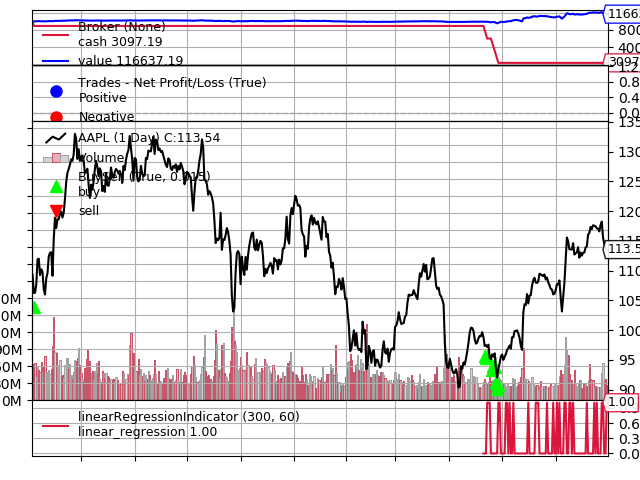

[[<Figure size 640x480 with 5 Axes>]]

In [7]:
cerebro.plot()